# Converage type detection using Softmax

The dataset was obtained from [UCI Machine learning repository](https://archive.ics.uci.edu/ml/datasets/Covertype)

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
%matplotlib inline

In [2]:
# read data into a DataFrame    
data = pd.read_csv('~/Downloads/covtype.data')
data.head()

,2596,51,3,258,0,510,221,232,148,6279,...,0.34,0.35,0.36,0.37,0.38,0.39,0.40,0.41,0.42,5
0,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
1,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
2,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
3,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5
4,2579,132,6,300,-15,67,230,237,140,6031,...,0,0,0,0,0,0,0,0,0,2


In [3]:
data.describe()

,2596,51,3,258,0,510,221,232,148,6279,...,0.34,0.35,0.36,0.37,0.38,0.39,0.40,0.41,0.42,5
count,581011.000000,581011.000000,581011.000000,581011.000000,581011.000000,581011.000000,581011.000000,581011.000000,581011.000000,581011.000000,...,581011.000000,581011.000000,581011.000000,581011.000000,581011.000000,581011.000000,581011.000000,581011.000000,581011.000000,581011.000000
mean,2959.365926,155.656988,14.103723,269.428236,46.418935,2350.149779,212.146033,223.318701,142.528253,1980.283828,...,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060,2.051465
std,279.984569,111.913733,7.488234,212.549538,58.295250,1559.254343,26.769909,19.768711,38.274561,1324.184340,...,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121792,1.396500
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


In [13]:
def create_dataset(df):
    columns = df.shape[1]
    
    X1 = df[df.columns[0:10]]
    X1 = (X1 - X1.mean())/X1.std()
    X2 = df[df.columns[10:]]
    
    X = pd.concat([X1, X2], axis=1)    
    Y = pd.get_dummies(df[df.columns[columns - 1]])
    return X.values, Y.values

In [14]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=100)
train_X, train_Y = create_dataset(train_set)
test_X, test_Y = create_dataset(test_set)

In [15]:
def get_next_batch(X, Y, idx, batch_size):
    return X[idx*batch_size: (idx + 1)*batch_size], Y[idx*batch_size: (idx + 1)*batch_size]

In [16]:
def classification_model(train_X, train_Y, test_X, test_Y, layers = [], 
                         epochs=10, regularization=0.1, batch_size=10):
    weights = None
    bias = None
    
    assert(len(layers) > 1)
    assert(layers[0] == train_X.shape[1])
    L = layers
    feature_cnt = train_X.shape[1]
    class_cnt = test_Y.shape[1]
    # Mini Batch Gradient descent parameters
    batch_cnt = int(train_X.shape[0]/batch_size)
       
    X = tf.placeholder(tf.float32, shape=(None, feature_cnt))
    Y = tf.placeholder(tf.float32, shape=(None, class_cnt))

    w1 = tf.Variable(0.01*tf.random_normal(shape=(feature_cnt, L[1])))
    b1 = tf.Variable(tf.zeros(L[1], 1))
    Y1 = tf.nn.relu(tf.matmul(X, w1) + b1)
    
    w2 = tf.Variable(0.01*tf.random_normal(shape=(L[1], L[2])))
    b2 = tf.Variable(tf.zeros(L[2], 1))
    Y2 = tf.nn.relu(tf.matmul(Y1, w2) + b2)

    w = tf.Variable(0.01*tf.random_normal(shape=(L[2], L[3])))
    b = tf.Variable(tf.zeros(L[3], 1))    
    Y_predicted = tf.nn.softmax(tf.matmul(Y2, w) + b) 
    
    loss = -1000.0*tf.reduce_mean(Y*tf.log(Y_predicted))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.005).minimize(loss)
    
    train_losses = []
    test_losses = []
  
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for i in range(epochs):
            for idx in range(0, batch_cnt):
                mini_X, mini_Y = get_next_batch(train_X, train_Y, idx, batch_size)
            
                train_loss_val,_ = sess.run([loss, optimizer], feed_dict={X: mini_X, Y: mini_Y})
                train_losses.append(train_loss_val)
                
                test_loss_val = sess.run([loss], feed_dict={X: test_X, Y: test_Y})
                test_losses.append(test_loss_val)
    
                
        plt.plot(range(0, epochs*batch_cnt), train_losses, '-',label='training')
        plt.plot(range(0, epochs*batch_cnt), test_losses, '-', label='test')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()  
       
        # Test the regression model
        correct_predictions = tf.equal(tf.argmax(Y_predicted, 1), tf.argmax(test_Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
        return sess.run(accuracy, feed_dict={X: test_X, Y: test_Y})

(464808, 55)
[55, 110, 27, 7]


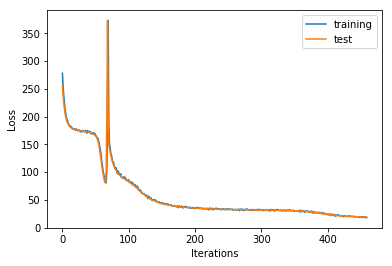

0.949648


In [17]:
feature_cnt = train_X.shape[1]
print(train_X.shape)
layers = list(map(int, [feature_cnt, 2*feature_cnt, feature_cnt/2, train_Y.shape[1]]))
print(layers)
accuracy = classification_model(train_X, train_Y, test_X, test_Y, layers=layers, batch_size=10000)
print(accuracy)